In [1]:

# Importación de librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import xgboost as xgb
from xgboost import XGBRegressor
import joblib

# Configuración para la visualización
%matplotlib inline
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)


C:\Users\fprada\AppData\Local\Temp\ipykernel_8444\3239715818.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:

# Carga de los datos
data_path = 'C:\\Users\\fprada\\Desktop\\Fer\\Kaggle\\ML_Time_Series\\ts_kaggle_train.csv'  # Asegúrate de tener la ruta correcta al archivo
df = pd.read_csv(data_path)

# Visualización de las primeras filas del conjunto de datos
df.head()


,Unnamed: 0,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
0,0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0
1,1,2013-01-31,12_11369,16,12,9,11369,572.715278,30.0
2,2,2013-01-31,12_11370,16,12,9,11370,699.776786,30.0
3,3,2013-01-31,12_11373,16,12,9,11373,548.900000,6.0
4,4,2013-01-31,12_12231,16,12,49,12231,350.000000,3.0


In [3]:

# Información general del DataFrame
df.info()

# Estadísticas descriptivas
df.describe()

# Verificación de valores nulos
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14484 entries, 0 to 14483
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             14484 non-null  int64  
 1   date                   14484 non-null  object 
 2   unique_id              14484 non-null  object 
 3   city_id                14484 non-null  int64  
 4   shop_id                14484 non-null  int64  
 5   item_category_id       14484 non-null  int64  
 6   item_id                14484 non-null  int64  
 7   monthly_average_price  13262 non-null  float64
 8   monthly_sales          13756 non-null  float64
dtypes: float64(2), int64(5), object(2)
memory usage: 1018.5+ KB


Unnamed: 0                  0
date                        0
unique_id                   0
city_id                     0
shop_id                     0
item_category_id            0
item_id                     0
monthly_average_price    1222
monthly_sales             728
dtype: int64

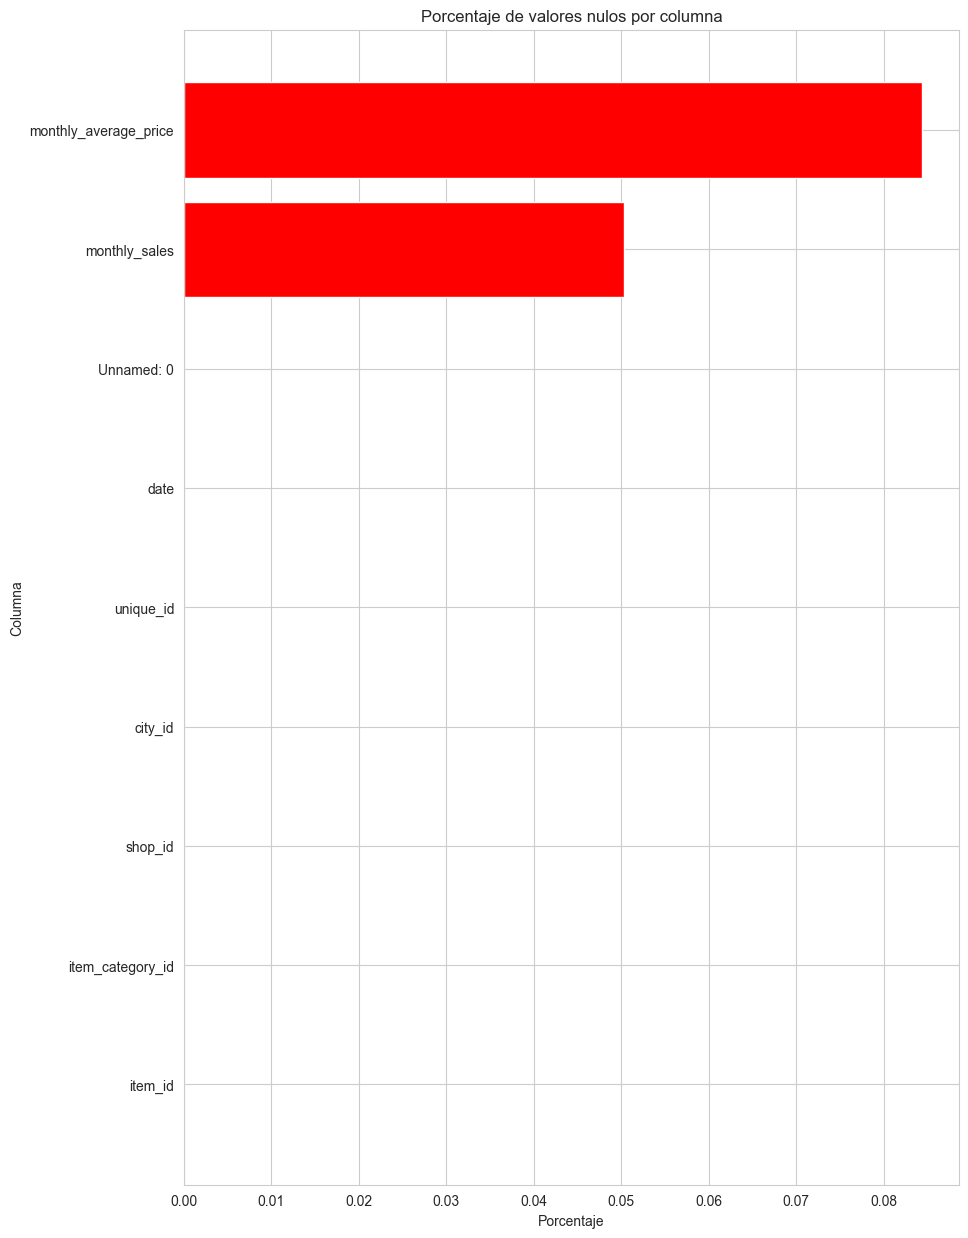

In [4]:

# Aquí trabajamos con los valores nulos. Donde crearé unj gráfico para verlos de manera mas visual
df_null_values = df.isnull().mean().sort_values(ascending=False)

fig, ax= plt.subplots(figsize=(10,15))

#Creo el gráfico de barras horizontales
ax.barh(y= df_null_values.index, #Posiciono las barras según los indices
        width=df_null_values,
        color='red')

# Invierto el eje Y para que las columnas aparezcan en el orden correcto
ax.invert_yaxis()

plt.title('Porcentaje de valores nulos por columna')
plt.xlabel('Porcentaje')
plt.ylabel('Columna')

plt.show()

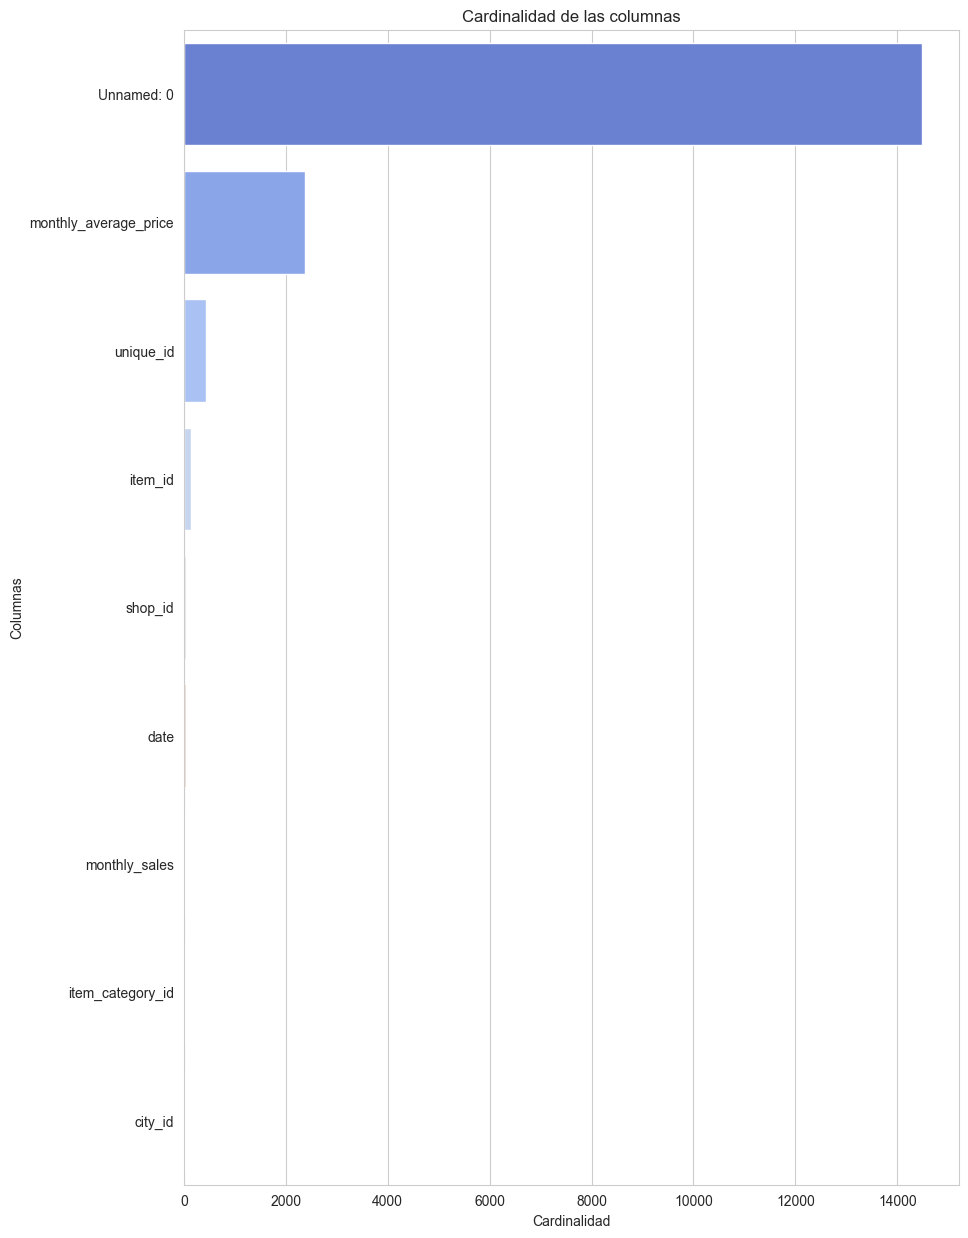

In [5]:
# Calculo la cardinalidad del modelo para tener una mayor compresión de los datos
cardinalidad = df.nunique()
df_cardinalidad = pd.DataFrame({'column': cardinalidad.index, 'cardinalidad': cardinalidad.values})
df_cardinalidad = df_cardinalidad.sort_values(by='cardinalidad', ascending=False)

fig,ax=plt.subplots(figsize= (10,15))
sns.barplot(x='cardinalidad', y='column', data=df_cardinalidad, palette='coolwarm',hue='column', legend=False)

plt.title('Cardinalidad de las columnas')
plt.xlabel('Cardinalidad')
plt.ylabel('Columnas')

plt.show()

In [6]:
df2=df.copy()

In [7]:
# Imputo valores nulos y defino varias tareas a realizar en una Pipeline
num_features = ['monthly_average_price']
cat_features = ['city_id', 'shop_id', 'item_category_id']

#Pipeline para las características numéricas
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

#Pipeline para características categóricas
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=-1)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

#Combino las pipelines anteriores
preprocessor = ColumnTransformer([
    ('num', num_pipe, num_features),
    ('cat', cat_pipe, cat_features)
])

#Pipeline final
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(objective='reg:squarederror'))
])

In [8]:
df_preprocessed = df.copy()

if 'date' in df_preprocessed.columns:
    df_preprocessed['year'] = pd.to_datetime(df_preprocessed['date']).dt.year
    df_preprocessed['month'] = pd.to_datetime(df_preprocessed['date']).dt.month
    df_preprocessed['day'] = pd.to_datetime(df_preprocessed['date']).dt.day
    df_preprocessed.drop(['date'], axis=1, inplace=True)

if 'unique_id' in df_preprocessed.columns:
    df_preprocessed.drop(['unique_id'], axis=1, inplace=True)

In [9]:
# Defino las características (X) y la variable objetivo (y) utilizando el conjunto de datos preprocesado
X = df_preprocessed.drop(['monthly_sales'], axis=1)  # Me aseguro de reemplazar 'monthly_sales' con la variable objetivo real
y = df_preprocessed['monthly_sales']

# Divido el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Verifico si hay valores NaN en y_train
print("Valores NaN en y_train:", y_train.isna().sum())

Valores NaN en y_train: 591


In [11]:
# Hay 591 por lo procedo a imputarlos usando la mediana
y_train.fillna(y_train.median(), inplace=True)

# Ahora verifico si hay valores infinitos y, en caso de haberlos, los reemplazo
y_train.replace([np.inf, -np.inf], np.nan, inplace=True)
y_train.fillna(y_train.median(), inplace=True)


In [12]:
print(y_train.describe())

count    11587.000000
mean         7.255113
std          7.751068
min          0.000000
25%          2.000000
50%          5.000000
75%          8.000000
max         30.000000
Name: monthly_sales, dtype: float64


In [13]:
y_train = np.log1p(y_train)

In [14]:
# Optimización de Hiperparámetros
param_grid= {
    'model__n_estimators': [50,100,150], # Número de árboles
    'model__max_depth': [3,6,9], # Profundidad máxima del árbol
    'model__learning_rate': [0.01, 0.1, 0.3], #Tasa de aprendizaje
    'model__subsample': [0.8, 0.9, 1], # Porcentaje de muestras utilizadas para cada árbol
    'model__colsample_bytree':[0.8, 0.9, 1] # Porcentaje de características utilizadas para cada árbol
}

# Inicializo el GridSearchCV
grid_search= GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# Entrenamiento usando GridSearchCV
grid_search.fit(X_train, y_train)

# Mejores hiperparámetros
print("Mejores hipermarámetros:", grid_search.best_params_)

# Mejor puntuación obtenida
print("Mejor puntuación:", grid_search.best_score_)

# Mejor modelo encontrado

best_model = grid_search.best_estimator_


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Mejores hipermarámetros: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.3, 'model__max_depth': 6, 'model__n_estimators': 100, 'model__subsample': 1}
Mejor puntuación: -0.3102426302768521


## Entrenamiento del modelo

In [15]:
# Ahora que he sacado los mejores hiperparámetros y el MSE voy a entrenar el modelo XGBoost
best_params = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.3,
    'max_depth': 6,
    'n_estimators': 100,
    'subsample': 1,
    'objective': 'reg:squarederror'
}
final_model = XGBRegressor(**best_params)

# Entreno el modelo con el conjunto completo de datos de entrenamiento
final_model.fit(X_train, y_train)

# Guardo el modelo por si lo reutilizo mas adelante
joblib.dump(final_model, 'final_model_xgb.joblib')


['final_model_xgb.joblib']

In [16]:
# Filtro las observaciones donde y_test no es NaN
mask = ~y_test.isnull()  # Creo una máscara para las observaciones no NaN
filtered_y_test = y_test[mask]  # Aplico la máscara a y_test

## Evaluación del modelo

In [17]:
# Para columnas numéricas, rellenamos los NaNs con la media de la columna
for col in X_train.columns:
    X_train[col] = X_train[col].fillna(X_train[col].mean())
    X_test[col] = X_test[col].fillna(X_train[col].mean()) # Usamos la media del conjunto de entrenamiento para el conjunto de prueba

# Para columnas categóricas, rellenamos los NaNs con el valor más frecuente
for col in X_train.columns:
    if X_train[col].dtype == 'object':  # Asumo que las columnas categóricas son de tipo 'object'
        most_frequent = X_train[col].mode()[0]
        X_train[col].fillna(most_frequent, inplace=True)
        X_test[col].fillna(most_frequent, inplace=True)

# Verificamos que no haya NaNs restantes
assert X_train.isnull().sum().sum() == 0
assert X_test.isnull().sum().sum() == 0


# Elimina filas con NaN
X_train.dropna(inplace=True)
X_test.dropna(inplace=True)

# Entrenamiento del modelo con X_train
final_model.fit(X_train, y_train)

# Predicciones con X_test
y_pred = final_model.predict(X_test)


In [18]:
# Identificar índices donde y_test es NaN
nan_indices = y_test[y_test.isnull()].index

# Eliminar esos índices tanto de X_test como de y_test
X_test = X_test.drop(index=nan_indices)
y_test = y_test.drop(index=nan_indices)

In [19]:
print("NaN en y_test:", y_test.isnull().sum())
print("NaN en y_pred:", np.isnan(y_pred).sum())

NaN en y_test: 0
NaN en y_pred: 0


In [20]:
print("Tamaño de y_test después de la limpieza:", y_test.shape)
print("Tamaño de y_pred:", y_pred.shape)

Tamaño de y_test después de la limpieza: (2760,)
Tamaño de y_pred: (2897,)


In [21]:
# Haciendo comprobaciones para ver el tamaño de los datos en y_test y y_pred, observo que hay discrepancias entre ambas variables por lo que procedo a solventarlas

# Identifico los índices donde y_test es NaN
nan_indices = y_test[y_test.isnull()].index

# Luego, elimino esos índices tanto de X_test como de y_test
X_test_cleaned = X_test.drop(index=nan_indices)
y_test_cleaned = y_test.drop(index=nan_indices)

# Verifico que las dimensiones de X_test_cleaned y y_test_cleaned son las mismas
assert X_test_cleaned.shape[0] == y_test_cleaned.shape[0], "X_test_cleaned y y_test_cleaned deben tener el mismo número de filas"

# Genero predicciones con X_test_cleaned
y_pred = final_model.predict(X_test_cleaned)

# Compruebo que el tamaño de y_pred y y_test_cleaned son iguales
assert y_pred.shape[0] == y_test_cleaned.shape[0], "y_pred y y_test_cleaned deben tener el mismo número de filas"


In [22]:
# Cálculo de métricas
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R2: {r2}')

MSE: 82.11045329674158
RMSE: 9.061481848833644
MAE: 5.524311989656838
R2: -0.34312316885339955


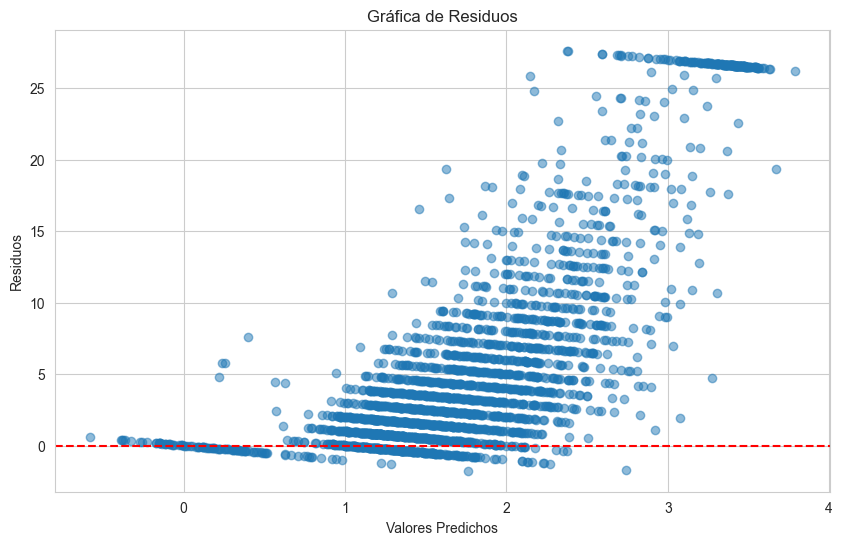

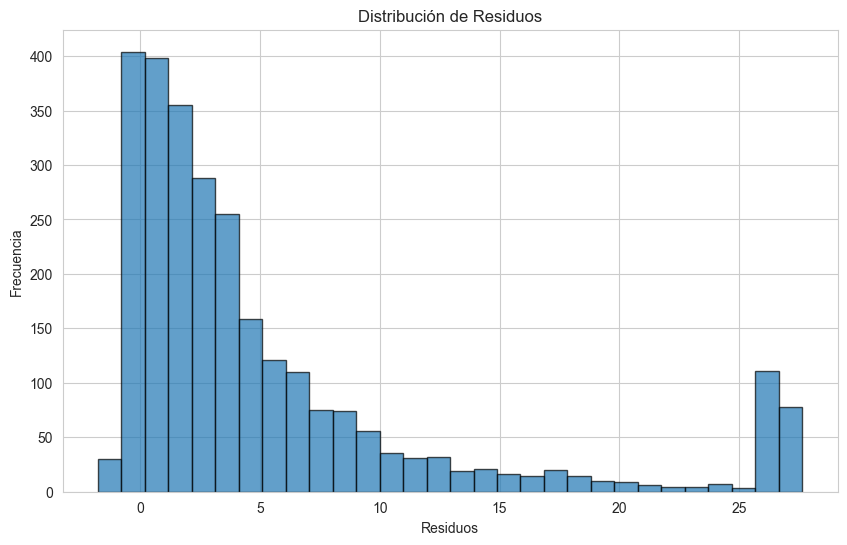

In [23]:
# Sigo con esta celda que me ayuda a analizar los residuos para identificar si hay algún patrón sistemático en los errores del modelo que puedan ser corregidos

# Calculo los residuos
residuos = y_test - y_pred

# Gráfica de residuos
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuos, alpha=0.5)
plt.title('Gráfica de Residuos')
plt.xlabel('Valores Predichos')
plt.ylabel('Residuos')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

# Histograma de los residuos
plt.figure(figsize=(10, 6))
plt.hist(residuos, bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribución de Residuos')
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.show()

## Observaciones

 Gráfico de residuos:

 Este primer gráfico me muestra las diferencias entre los valores reales y los que ha predicho el modelo. Lo ideal es que estos valores estén dispersos de forma aleatoria alrededor de la línea horizontal y=0 sin formar un patrón claro. Sin embargo, se puede apreciar un patrón en la dispersión de los residuos donde, para valores mas altos, el modelo tiende a sobreestimar las predicciones

 Histograma de residuos:

Muestra a distribución de los residuos. En una situación ideal, este gráfico debería acercarse a una distribución normal con su centro en el 0. La asimetría del modelo indica que se substiman las ventas. También se muestra uun pico pronunciado para un rango de residuos altos, surgiese que hay instancias donde el modelo se equivoca por un margen bastante elevado.